<h3>Import Libraries

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

<h3> Read Data

In [2]:
female_adult_ratings = pd.read_csv('processed_data/female_adult_ratings.csv')

In [3]:
female_adult_ratings.shape

(4457, 6)

<h1> Bandit Simulator

In [4]:
from tqdm import tqdm

class ReplaySimulator(object):
    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, random_seed=1):
        # Set the random seed for reproducibility
        np.random.seed(random_seed)

        # Store input data and parameters
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # Number of visits to replay/simulate
        self.n_visits = n_visits

        # Number of runs to average over
        self.n_iterations = n_iterations

        # Items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)

        # Visitors in the historical reward_history
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)

    def reset(self):
        # Initialize counters for item samples and rewards
        self.n_item_samples = np.zeros(self.n_items)
        self.n_item_rewards = np.zeros(self.n_items)

    def replay(self):
        # Store simulation results
        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
            # Reset counters for each iteration
            self.reset()

            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
                found_match = False
                while not found_match:
                    # Choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # Select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]

                    # Check if this interaction exists in the history
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]

                    found_match = reward.shape[0] > 0

                reward_value = reward.iloc[0]

                self.record_result(visit, item_idx, reward_value)

                # Record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)

                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)

                results.append(result)

        return results

    def select_item(self):
        # This method selects an item randomly
        return np.random.randint(self.n_items)

    def record_result(self, visit, item_idx, reward):
        # This method records the result of an interaction and updates item statistics

        # Update the number of times the item has been sampled
        self.n_item_samples[item_idx] += 1

        # Update the fraction of time the item has resulted in a reward
        alpha = 1. / self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])


# $\epsilon$-Greedy Simulations

In [5]:
# Initiate the list of best 5 recommendations
best_5_recommendations_fa = []

##### Update arm selection for $\epsilon$-Greedy

In [6]:
class EpsilonGreedyReplayer(ReplaySimulator):
    '''
    A class to provide functionality for simulating the replayer method on an epsilon-Greedy bandit algorithm.
    '''

    def __init__(self, epsilon, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        super(EpsilonGreedyReplayer, self).__init__(n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations)
    
        # parameter to control exploration vs exploitation
        self.epsilon = epsilon
    
    def select_item(self):
        
        # decide to explore or exploit
        if np.random.uniform() < self.epsilon: # explore
            item_id = super(EpsilonGreedyReplayer, self).select_item()
            
        else: # exploit
            item_id = np.argmax(self.n_item_rewards)
            
        return item_id

### $\epsilon$ = 0.05

<h5> Initiate the parameters

In [7]:
n_visits = 20000
n_iterations = 20
n_test_visits = 1000

reward_history = female_adult_ratings
item_col_name = 'movie_id'
visitor_col_name = 'user_id'
reward_col_name = 'like'

In [8]:
epsilon = 0.05
epsilon_05_results_fa = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_05_results_fa_df = pd.DataFrame(epsilon_05_results_fa)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [16:41<00:00, 50.08s/it]


In [9]:
epsilon_05_results_fa_df.to_csv('output/epsilon_05_results_1_fa.csv')

In [10]:
epsilon_05_results_fa_df = pd.read_csv('output/epsilon_05_results_1_fa.csv')

In [11]:
# Create a dataframe with running totals of how many times each recommendation was taken
epsilon_05_fa_running_ttl = epsilon_05_results_fa_df.query('iteration == 0') \
                                .assign(selected=1) \
                                .pivot(index='visit', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index()

# Scale the value by the visit number to get turn the running total into a percentage
epsilon_05_fa_running_ttl.iloc[:,1:] = epsilon_05_fa_running_ttl.iloc[:,1:].div((epsilon_05_fa_running_ttl.visit + 1)/100, axis=0)

In [12]:
# View the results in the final iteration in descending order
final_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest()
final_recommendations_05_fa

item_id
318    92.895
515     1.145
286     0.195
302     0.195
100     0.190
Name: 19999, dtype: float64

In [13]:
item_ids = female_adult_ratings['movie_id'].unique()
color_map = {item_id: f'C{i}' for i, item_id in enumerate(item_ids, start=1)}

movie_names = {row['movie_id']: row['movie title'] for i, row in female_adult_ratings.iterrows()}

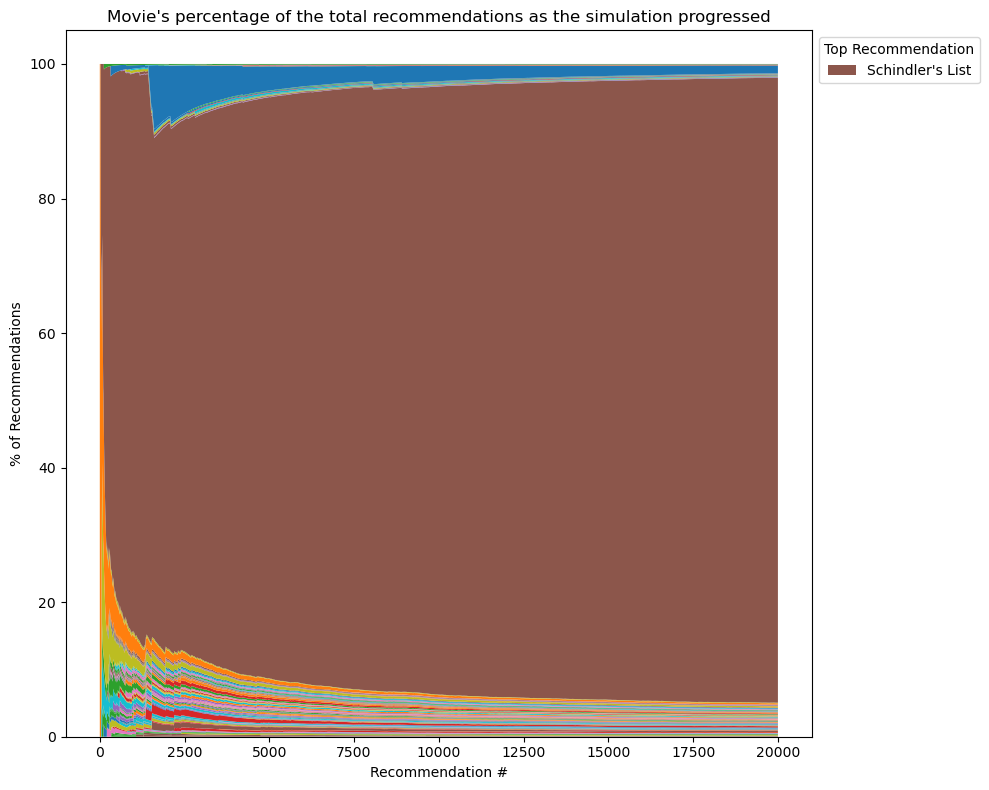

In [14]:
fig, ax = plt.subplots(figsize=(10,8))

item_ids = epsilon_05_fa_running_ttl.columns[1:]

top_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest(1).index

ax.stackplot(epsilon_05_fa_running_ttl.visit,
             epsilon_05_fa_running_ttl.iloc[:,1:].T,
             labels=[movie_names[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values],
             colors=[color_map[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values]
            )


ax.set_title('Movie\'s percentage of the total recommendations as the simulation progressed')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

# Find the color and label for the top recommendation
top_label_05_fa = movie_names[top_recommendations_05_fa[0]]
top_color_05_fa = color_map[top_recommendations_05_fa[0]]
top_rectangle_05_fa = plt.Rectangle((0, 0), 1, 1, fc=top_color_05_fa, label=top_label_05_fa)

# Create the custom legend for the top recommendation
lgd = ax.legend(handles=[top_rectangle_05_fa], loc='upper left', bbox_to_anchor=(1, 1), title="Top Recommendation")

ax.set_facecolor('w')

plt.tight_layout()
plt.show()

In [15]:
best_recommendation_id = final_recommendations_05_fa.nlargest(1).index[0]
best_recommendation_title = movie_names[best_recommendation_id]
print(f'Best recommendation: "{best_recommendation_title}" (Movie ID: {best_recommendation_id})')

Best recommendation: "Schindler's List" (Movie ID: 318)


From the results, it is evident that movie 'Schindler's List' (ID 318) is consistently chosen as the best recommendation during exploitation.  
However, the sequence of the remaining movie IDs does not provide substantial insight into determining the most favorable recommendations, as they collectively make up a very small percentage of selections.  
Hence, instead of taking the 5 movies of the highest percentage as the best 5 recommendations, we should iteratively find the best movie selected by the multi-armed bandit algorithm until we find the set of best 5 recommendations

In [16]:
best_5_recommendations_fa.append(best_recommendation_title)

In [17]:
print(f'View of the selected recommendations: {best_5_recommendations_fa}')

View of the selected recommendations: ["Schindler's List"]


### `Second Iteration`

In [18]:
# Remove ratings of the best recommendation in last iteration
female_adult_ratings_2 = female_adult_ratings[female_adult_ratings['movie title'] != best_recommendation_title]
female_adult_ratings_2.shape

(4416, 6)

In [19]:
# Update the rewards_history
reward_history = female_adult_ratings_2

In [20]:
epsilon = 0.05
epsilon_05_results_fa = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_05_results_fa_df = pd.DataFrame(epsilon_05_results_fa)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [16:47<00:00, 50.38s/it]


In [21]:
# Write the results of the second iteration to the csv file
epsilon_05_results_fa_df.to_csv('output/epsilon_05_results_2_fa.csv')

In [22]:
epsilon_05_results_fa_df = pd.read_csv('output/epsilon_05_results_2_fa.csv')

In [23]:
# Create a dataframe with running totals of how many times each recommendation was taken
epsilon_05_fa_running_ttl = epsilon_05_results_fa_df.query('iteration == 0') \
                                .assign(selected=1) \
                                .pivot(index='visit', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index()

# Scale the value by the visit number to get turn the running total into a percentage
epsilon_05_fa_running_ttl.iloc[:,1:] = epsilon_05_fa_running_ttl.iloc[:,1:].div((epsilon_05_fa_running_ttl.visit + 1)/100, axis=0)

In [24]:
# View the results in the final iteration in descending order
final_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest()
final_recommendations_05_fa

item_id
275    48.88
100    38.84
64      3.33
185     2.91
180     0.67
Name: 19999, dtype: float64

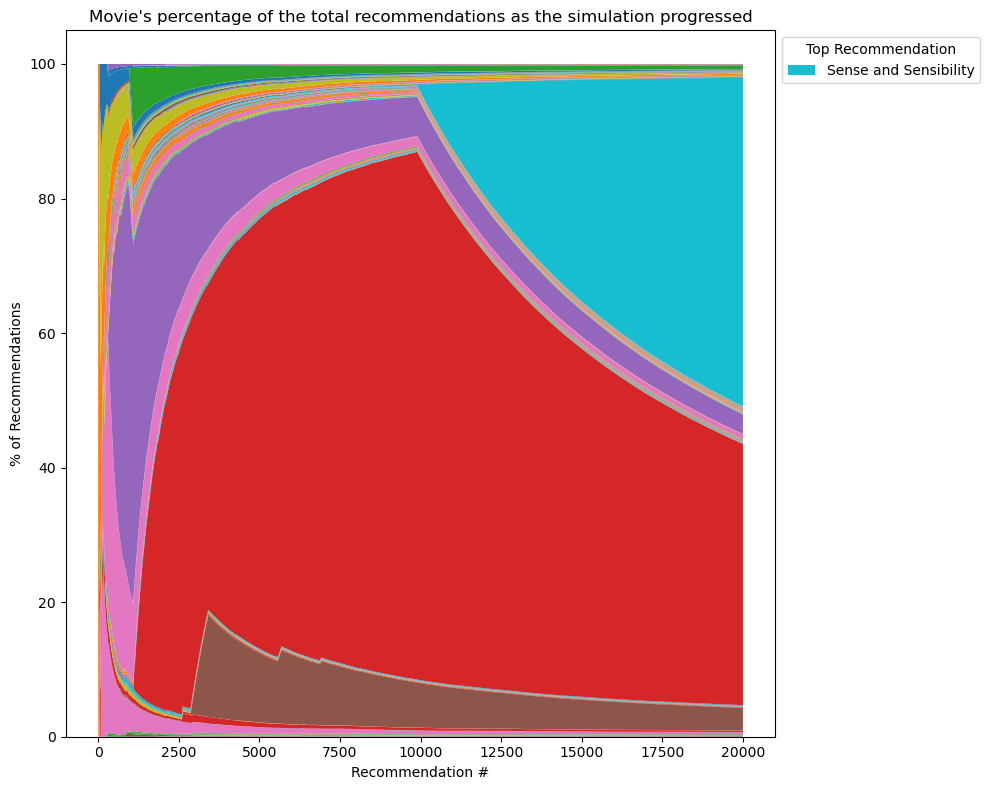

In [25]:
fig, ax = plt.subplots(figsize=(10,8))

item_ids = epsilon_05_fa_running_ttl.columns[1:]

top_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest(1).index

ax.stackplot(epsilon_05_fa_running_ttl.visit,
             epsilon_05_fa_running_ttl.iloc[:,1:].T,
             labels=[movie_names[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values],
             colors=[color_map[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values]
            )


ax.set_title('Movie\'s percentage of the total recommendations as the simulation progressed')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

# Find the color and label for the top recommendation
top_label_05_fa = movie_names[top_recommendations_05_fa[0]]
top_color_05_fa = color_map[top_recommendations_05_fa[0]]
top_rectangle_05_fa = plt.Rectangle((0, 0), 1, 1, fc=top_color_05_fa, label=top_label_05_fa)

# Create the custom legend for the top recommendation
lgd = ax.legend(handles=[top_rectangle_05_fa], loc='upper left', bbox_to_anchor=(1, 1), title="Top Recommendation")

ax.set_facecolor('w')

plt.tight_layout()
plt.show()

In [26]:
best_recommendation_id = final_recommendations_05_fa.nlargest(1).index[0]
best_recommendation_title = movie_names[best_recommendation_id]
print(f'Best recommendation: "{best_recommendation_title}" (Movie ID: {best_recommendation_id})')

Best recommendation: "Sense and Sensibility" (Movie ID: 275)


In [27]:
best_5_recommendations_fa.append(best_recommendation_title)

In [28]:
print(f'View of the selected recommendations: {best_5_recommendations_fa}')

View of the selected recommendations: ["Schindler's List", 'Sense and Sensibility']


### `Third Iteration`

In [29]:
# Remove ratings of the best recommendation in last iteration
female_adult_ratings_3 = female_adult_ratings_2[female_adult_ratings_2['movie title'] != best_recommendation_title]
female_adult_ratings_3.shape

(4359, 6)

In [30]:
# Update the rewards_history
reward_history = female_adult_ratings_3

In [31]:
epsilon = 0.05
epsilon_05_results_fa = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_05_results_fa_df = pd.DataFrame(epsilon_05_results_fa)

100%|██████████| 20/20 [17:34<00:00, 52.71s/it]


In [32]:
# Write the results of the third iteration to the csv file
epsilon_05_results_fa_df.to_csv('output/epsilon_05_results_3_fa.csv')

In [33]:
epsilon_05_results_fa_df = pd.read_csv('output/epsilon_05_results_3_fa.csv')

In [34]:
# Create a dataframe with running totals of how many times each recommendation was taken
epsilon_05_fa_running_ttl = epsilon_05_results_fa_df.query('iteration == 0') \
                                .assign(selected=1) \
                                .pivot(index='visit', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index()

# Scale the value by the visit number to get turn the running total into a percentage
epsilon_05_fa_running_ttl.iloc[:,1:] = epsilon_05_fa_running_ttl.iloc[:,1:].div((epsilon_05_fa_running_ttl.visit + 1)/100, axis=0)

In [35]:
# View the results in the final iteration in descending order
final_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest()
final_recommendations_05_fa

item_id
483    84.445
603     4.385
79      3.595
100     0.615
50      0.250
Name: 19999, dtype: float64

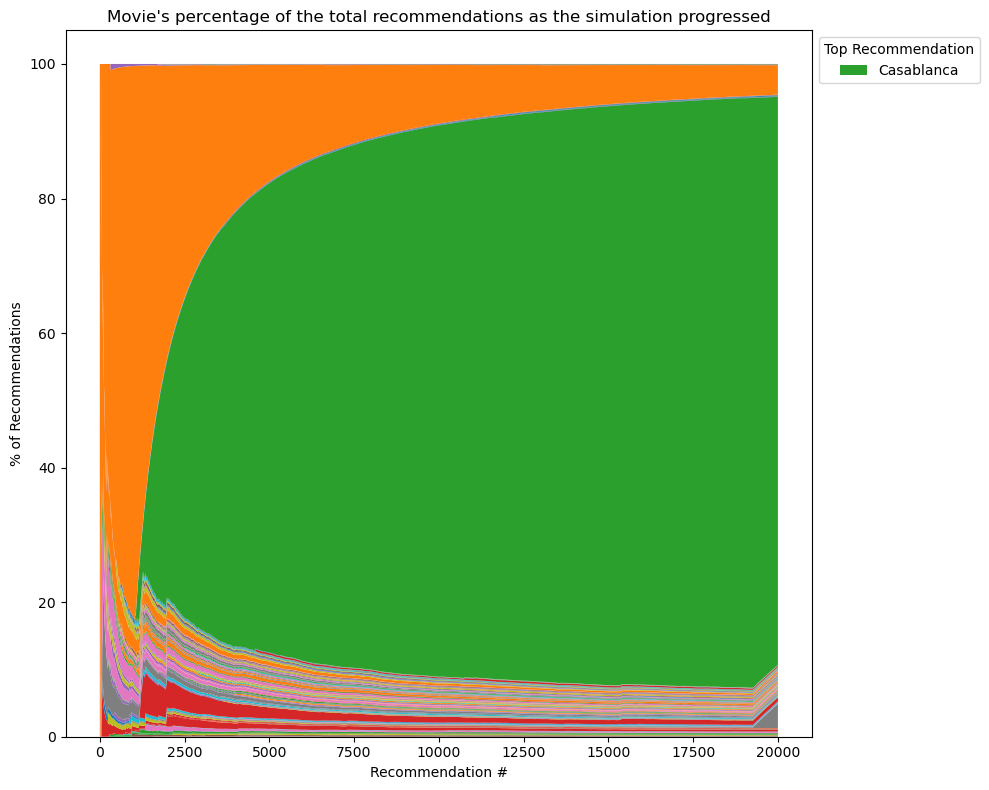

In [36]:
fig, ax = plt.subplots(figsize=(10,8))

item_ids = epsilon_05_fa_running_ttl.columns[1:]

top_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest(1).index

ax.stackplot(epsilon_05_fa_running_ttl.visit,
             epsilon_05_fa_running_ttl.iloc[:,1:].T,
             labels=[movie_names[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values],
             colors=[color_map[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values]
            )


ax.set_title('Movie\'s percentage of the total recommendations as the simulation progressed')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

# Find the color and label for the top recommendation
top_label_05_fa = movie_names[top_recommendations_05_fa[0]]
top_color_05_fa = color_map[top_recommendations_05_fa[0]]
top_rectangle_05_fa = plt.Rectangle((0, 0), 1, 1, fc=top_color_05_fa, label=top_label_05_fa)

# Create the custom legend for the top recommendation
lgd = ax.legend(handles=[top_rectangle_05_fa], loc='upper left', bbox_to_anchor=(1, 1), title="Top Recommendation")

ax.set_facecolor('w')

plt.tight_layout()
plt.show()

In [37]:
best_recommendation_id = final_recommendations_05_fa.nlargest(1).index[0]
best_recommendation_title = movie_names[best_recommendation_id]
print(f'Best recommendation: "{best_recommendation_title}" (Movie ID: {best_recommendation_id})')

Best recommendation: "Casablanca" (Movie ID: 483)


In [38]:
best_5_recommendations_fa.append(best_recommendation_title)

In [39]:
print(f'View of the selected recommendations: {best_5_recommendations_fa}')

View of the selected recommendations: ["Schindler's List", 'Sense and Sensibility', 'Casablanca']


### `Fourth Iteration`

In [40]:
# Remove ratings of the best recommendation in last iteration
female_adult_ratings_4 = female_adult_ratings_3[female_adult_ratings_3['movie title'] != best_recommendation_title]
female_adult_ratings_4.shape

(4325, 6)

In [41]:
# Update the rewards_history
reward_history = female_adult_ratings_4

In [42]:
epsilon = 0.05
epsilon_05_results_fa = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_05_results_fa_df = pd.DataFrame(epsilon_05_results_fa)

100%|██████████| 20/20 [17:37<00:00, 52.87s/it]


In [43]:
# Write the results of the fourth iteration to the csv file
epsilon_05_results_fa_df.to_csv('output/epsilon_05_results_4_fa.csv')

In [44]:
epsilon_05_results_fa_df =  pd.read_csv('output/epsilon_05_results_4_fa.csv')

In [45]:
# Create a dataframe with running totals of how many times each recommendation was taken
epsilon_05_fa_running_ttl = epsilon_05_results_fa_df.query('iteration == 0') \
                                .assign(selected=1) \
                                .pivot(index='visit', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index()

# Scale the value by the visit number to get turn the running total into a percentage
epsilon_05_fa_running_ttl.iloc[:,1:] = epsilon_05_fa_running_ttl.iloc[:,1:].div((epsilon_05_fa_running_ttl.visit + 1)/100, axis=0)

In [46]:
# View the results in the final iteration in descending order
final_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest()
final_recommendations_05_fa

item_id
515    63.795
185    24.160
100     3.115
180     0.670
50      0.550
Name: 19999, dtype: float64

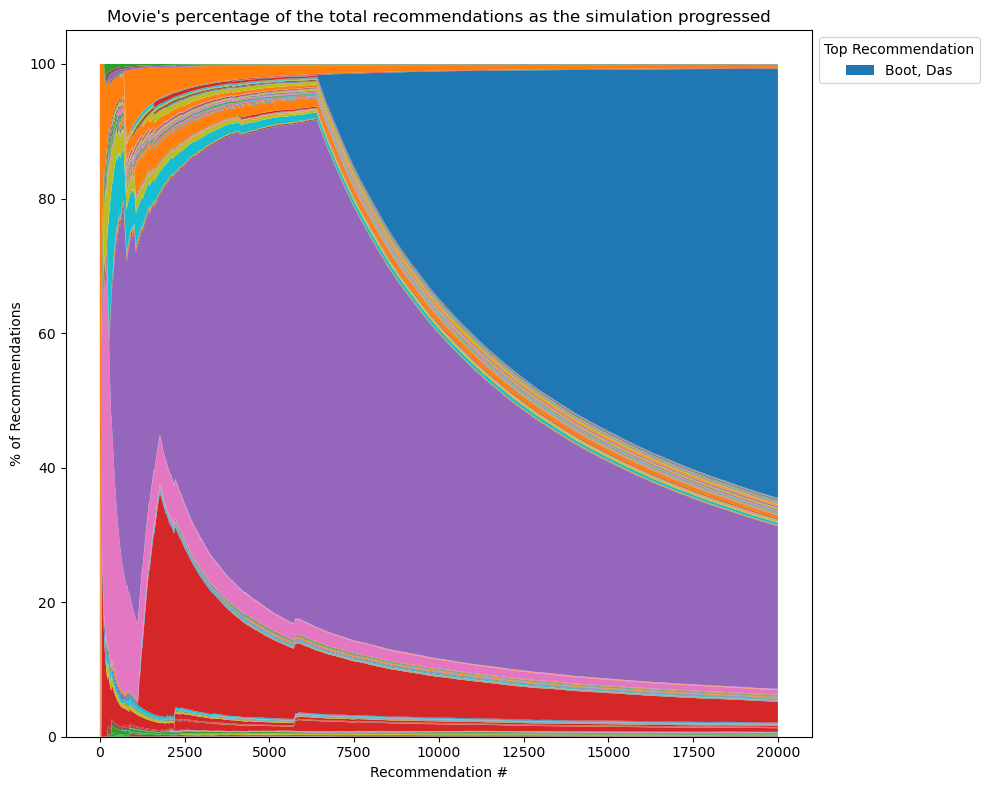

In [47]:
fig, ax = plt.subplots(figsize=(10,8))

item_ids = epsilon_05_fa_running_ttl.columns[1:]

top_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest(1).index

ax.stackplot(epsilon_05_fa_running_ttl.visit,
             epsilon_05_fa_running_ttl.iloc[:,1:].T,
             labels=[movie_names[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values],
             colors=[color_map[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values]
            )


ax.set_title('Movie\'s percentage of the total recommendations as the simulation progressed')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

# Find the color and label for the top recommendation
top_label_05_fa = movie_names[top_recommendations_05_fa[0]]
top_color_05_fa = color_map[top_recommendations_05_fa[0]]
top_rectangle_05_fa = plt.Rectangle((0, 0), 1, 1, fc=top_color_05_fa, label=top_label_05_fa)

# Create the custom legend for the top recommendation
lgd = ax.legend(handles=[top_rectangle_05_fa], loc='upper left', bbox_to_anchor=(1, 1), title="Top Recommendation")

ax.set_facecolor('w')

plt.tight_layout()
plt.show()

In [48]:
best_recommendation_id = final_recommendations_05_fa.nlargest(1).index[0]
best_recommendation_title = movie_names[best_recommendation_id]
print(f'Best recommendation: "{best_recommendation_title}" (Movie ID: {best_recommendation_id})')

Best recommendation: "Boot, Das" (Movie ID: 515)


In [49]:
best_5_recommendations_fa.append(best_recommendation_title)

In [50]:
print(f'View of the selected recommendations: {best_5_recommendations_fa}')

View of the selected recommendations: ["Schindler's List", 'Sense and Sensibility', 'Casablanca', 'Boot, Das']


### `Fifth Iteration`

In [51]:
# Remove ratings of the best recommendation in last iteration
female_adult_ratings_5 = female_adult_ratings_4[female_adult_ratings_4['movie title'] != best_recommendation_title]
female_adult_ratings_5.shape

(4296, 6)

In [52]:
# Update the rewards_history
reward_history = female_adult_ratings_5

In [53]:
epsilon = 0.05
epsilon_05_results_fa = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).replay()
epsilon_05_results_fa_df = pd.DataFrame(epsilon_05_results_fa)

100%|██████████| 20/20 [16:57<00:00, 50.88s/it]


In [54]:
# Write the results of the fifth iteration to the csv file
epsilon_05_results_fa_df.to_csv('output/epsilon_05_results_5_fa.csv')

In [55]:
# Create a dataframe with running totals of how many times each recommendation was taken
epsilon_05_fa_running_ttl = epsilon_05_results_fa_df.query('iteration == 0') \
                                .assign(selected=1) \
                                .pivot(index='visit', columns='item_id', values='selected') \
                                .fillna(0) \
                                .cumsum(axis=0) \
                                .reset_index()

# Scale the value by the visit number to get turn the running total into a percentage
epsilon_05_fa_running_ttl.iloc[:,1:] = epsilon_05_fa_running_ttl.iloc[:,1:].div((epsilon_05_fa_running_ttl.visit + 1)/100, axis=0)

In [56]:
# View the results in the final iteration in descending order
final_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest()
final_recommendations_05_fa

item_id
427    93.410
100     0.485
50      0.265
313     0.210
302     0.195
Name: 19999, dtype: float64

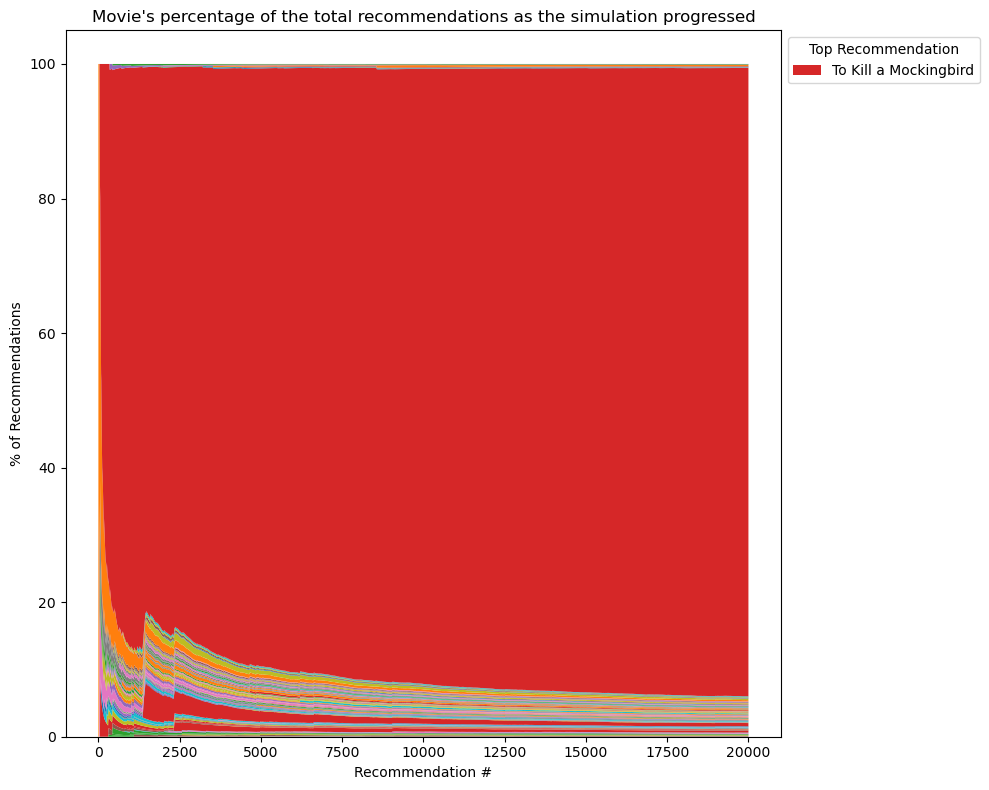

In [57]:
fig, ax = plt.subplots(figsize=(10,8))

item_ids = epsilon_05_fa_running_ttl.columns[1:]

top_recommendations_05_fa = epsilon_05_fa_running_ttl.iloc[-1, 1:].nlargest(1).index

ax.stackplot(epsilon_05_fa_running_ttl.visit,
             epsilon_05_fa_running_ttl.iloc[:,1:].T,
             labels=[movie_names[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values],
             colors=[color_map[x] for x in epsilon_05_fa_running_ttl.iloc[:,1:].columns.values]
            )


ax.set_title('Movie\'s percentage of the total recommendations as the simulation progressed')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recommendations')

# Find the color and label for the top recommendation
top_label_05_fa = movie_names[top_recommendations_05_fa[0]]
top_color_05_fa = color_map[top_recommendations_05_fa[0]]
top_rectangle_05_fa = plt.Rectangle((0, 0), 1, 1, fc=top_color_05_fa, label=top_label_05_fa)

# Create the custom legend for the top recommendation
lgd = ax.legend(handles=[top_rectangle_05_fa], loc='upper left', bbox_to_anchor=(1, 1), title="Top Recommendation")

ax.set_facecolor('w')

plt.tight_layout()
plt.show()

In [58]:
best_recommendation_id = final_recommendations_05_fa.nlargest(1).index[0]
best_recommendation_title = movie_names[best_recommendation_id]
print(f'Best recommendation: "{best_recommendation_title}" (Movie ID: {best_recommendation_id})')

Best recommendation: "To Kill a Mockingbird" (Movie ID: 427)


In [59]:
best_5_recommendations_fa.append(best_recommendation_title)

In [60]:
print(f'View of the selected recommendations: {best_5_recommendations_fa}')

View of the selected recommendations: ["Schindler's List", 'Sense and Sensibility', 'Casablanca', 'Boot, Das', 'To Kill a Mockingbird']


In [64]:
final_5_recommendations_05_fa = pd.DataFrame(best_5_recommendations_fa)
final_5_recommendations_05_fa.columns = ['Recommendation']
final_5_recommendations_05_fa

,Recommendation
0,Schindler's List
1,Sense and Sensibility
2,Casablanca
3,"Boot, Das"
4,To Kill a Mockingbird


In [65]:
final_5_recommendations_05_fa.to_csv("output/Female_Adult_recommendation.csv")